In [1]:
import numpy as np
from scipy import linalg
from scipy.stats import uniform, multivariate_normal, reciprocal, norm
from scipy.optimize import minimize, curve_fit
from scipy.stats import gaussian_kde

import os
import csv

import seaborn as sns; sns.set()
import math

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
cosmo = FlatLambdaCDM(H0=100. * u.km / u.s / u.Mpc, Om0=0.315)
from astropy.cosmology import Planck13, z_at_value
from astropy.modeling.models import Linear1D, Exponential1D
from astropy.io import fits
from astropy.table import Table

import emcee
import corner

import matplotlib.pyplot as plt
%matplotlib inline

def get_param_dict(par_names, pars):
    X = zip(par_names, pars)
    return dict(X)

## Cosmological Parameters

In [2]:
c = 299792.458 # km/s

# Cosmological parameters
Om0 = 0.315
h = 0.738
sigma80 = 0.622

## Tully-Fisher Parameters

In [3]:
# TF parameters from CF-4 2020:
a_TF = -8.32 #(0.13)
b_TF = -20.80 #(0.1)

#WBAR = 10 ** (-0.00039296407185628724+2.5)
#MBAR = a_TF*(np.log10(WBAR)-2.5) + b_TF + 5*np.log10(h)
a = a_TF
b = b_TF #+ 5*np.log10(h)
#XBAR = np.log10(WBAR)-2.5
#YBAR = a*XBAR + b

## Coordinate Transformations

In [4]:
## Coordinate transformtions (Cartesian and Equatorial)

def _eq_to_cart(ra, dec): 
    ra = ra*np.pi/180
    dec = dec*np.pi/180
    
    x = np.cos(ra) * np.cos(dec)
    y = np.sin(ra) * np.cos(dec)
    z = np.sin(dec)
    
    return x, y, z

def _cart_to_eq(x, y, z): 
    ra = np.arctan(y/x)
    dec = np.arcsin(z)
    
    ra = ra*180/np.pi
    dec = dec*180/np.pi
    
    return ra, dec

# RA, DEC to supergalactic cartesian coordinate transform
def sgxyz(ra, dec):
    
    ccc = SkyCoord(ra, dec, frame='icrs', unit='deg')
    xxx = ccc.transform_to('supergalactic')
    L = []
    
    p=180.0/math.pi
    
    sgl = xxx.sgl.value
    sgb = xxx.sgb.value

    L.append(math.cos(sgb/p)*math.cos(sgl/p))
    L.append(math.cos(sgb/p)*math.sin(sgl/p))    
    L.append(math.sin(sgb/p))
    return L

In [11]:
test = fits.open('alfalfa.fit')

In [12]:
test[0].header

SIMPLE  =                    T / Standard FITS Format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No Image --- just extension(s)                 
EXTEND  =                    T / There are standard extensions                  
ORIGIN  = 'xml2fits_v1.95'     / Converted from XML-Astrores to FITS            
                         e-mail: question@simbad.u-strasbg.fr                   
LONGSTRN= 'OGIP 1.0'           / Long string convention (&/CONTINUE) may be used
DATE    = '2021-12-08'         / Written on 2021-12-08:18:35:22 (GMT)           
                             by: www-data@vizier.astro.unistra.fr               
         **********************************************************             
             EXCERPT from catalogues stored in VizieR (CDS)                     
                        with the following conditions:                          
         *******************

In [13]:
def linewidth_corr(Wl, Wcl=100, Wtl=9):
    Wrl_sqrd = Wl**2 + ((Wtl**2)*(1- 2*np.exp(-(Wl/Wcl)**2))) - (2*Wl*Wtl*(1-np.exp(-(Wl/Wcl)**2)))
    
    Wrl = np.sqrt(abs(Wrl_sqrd))
    
    return Wrl

In [14]:
pgc_leda = np.load('hyperleda.npy')[0].astype(int)
name_leda = np.load('hyperleda.npy')[1]
ra_leda = np.load('hyperleda.npy')[2].astype(float)
dec_leda = np.load('hyperleda.npy')[3].astype(float)

In [15]:
logW_cf4 = np.load('cf4_data_names.npy')[2].astype(float)
LW_cf4 = np.load('cf4_data_names.npy')[4].astype(float)
z_cf4 = np.load('cf4_data_names.npy')[5].astype(float)/c
Imag_cf4_corr_dust = np.load('cf4_data_names.npy')[6].astype(float)
cf4_incl = np.deg2rad(np.load('cf4_data_names.npy')[3].astype(float))
VW_cf4 = LW_cf4/np.sin(cf4_incl)

name_cf4 = np.load('cf4_data_names.npy')[1]
pgc_cf4 = np.load('cf4_data_names.npy')[0].astype(int)

ra_cf4 = []
dec_cf4 = []
for pgc_id in pgc_cf4:
    found = np.where(pgc_leda == pgc_id)[0]
    if len(found)==1:
        ra_cf4.append(ra_leda[found[0]])
        dec_cf4.append(dec_leda[found[0]])
    else:
        ra_cf4.append(0)
        dec_cf4.append(0)
ra_cf4 = np.array(ra_cf4)
dec_cf4 = np.array(dec_cf4)

In [16]:
pos_cf4 = ra_cf4**2 + dec_cf4**2 +z_cf4**2

In [17]:
test = fits.open('alfalfa.fit')
AGC = np.array(Table(test[1].data)['AGC'])
NAME = np.array(Table(test[1].data)['Name'])
RAJ2000 = np.array(Table(test[1].data)['RAJ2000'])
DEJ2000 = np.array(Table(test[1].data)['DEJ2000'])
W50 = np.array(Table(test[1].data)['W50'])
e_W50 = np.array(Table(test[1].data)['e_W50'])
vHel = np.array(Table(test[1].data)['Vhel'])
#SNR = np.array(Table(test[1].data)['SNR'])
Dist = np.array(Table(test[1].data)['Dist'])

pgc_list = []
np.save('alfalfa_data.npy',np.array([np.array(W50), np.array(vHel)]))
        
with open('alfalfa_objects.csv', 'w') as f:
    writer = csv.writer(f)
    header = ["#No.",'RA', 'DEC', 'W50', 'e_W50','z', 'Dist']
    writer.writerow(header)

    for i in range(len(RAJ2000)):

        h, m, s = RAJ2000[i].split(' ')
        ra = 15*float(h)+15*float(m)/60+15*float(s)/3600
        d, m, s = DEJ2000[i].split(' ')
        dec = float(d)+float(m)/60+float(s)/3600
        zcmb = float(vHel[i])/c
        pos = ra**2 + dec**2 + zcmb**2
        if min(np.absolute(pos-pos_cf4)) < 1:
            find_gal = np.argmin(np.absolute(pos-pos_cf4))
            pgc_list.append(pgc_cf4[find_gal])
            writer.writerow([i+1, ra, dec, float(W50[i]), float(e_W50[i]),zcmb, float(Dist[i])])


In [18]:
pgc_inds = list(set(pgc_list))
pgc_inds.sort()
pgc_inds = np.array(pgc_inds)
pgc_inds = np.intersect1d(pgc_inds, pgc_cf4)
z_cf4_alfalfa = []
for pgc_id in pgc_inds:
    z_cf4_alfalfa.append(z_cf4[np.where(pgc_cf4==pgc_id)[0]][0])

z_cf4_alfalfa = np.array(z_cf4_alfalfa)
    

In [19]:
f1 = open("alfalfa_predpv_2M++.txt",'r')
#SNID IAUC RA_host Dec_host pv[km/s]    comoving_distance[Mpc/h100]   zcmb zHubble

beta_true = 0.43
#vext_true = np.array([95.0, -133.0, 4.0]) # SG cartesian coords, [x,y,z] km/s
vext_true = np.array([89.0, -131, 17.0]) # carrick et al 

RA = []
DEC = []
PV_norm = []
PV = []
VEXT_R = []
zobs = []
co_dist = []
zhubble = []
W50 = []

i = 0
for line in f1:
    if line[0]!='#':
        ra = float(line.split()[1])
        dec = float(line.split()[2])
        du = sgxyz(ra, dec) #unit direction of galaxy in SG frame
        vext_r = np.dot(du, vext_true) # bulk flow along the line-of-sight

        VEXT_R.append(vext_r)
        RA.append(ra)
        DEC.append(dec)
        PV_norm.append(((float(line.split()[3]))-vext_r)/beta_true)
        PV.append(float(line.split()[3]))
        co_dist.append(float(line.split()[4]))
        zobs.append(float(line.split()[5]))
        zhubble.append(float(line.split()[6]))
        W50.append(float(line.split()[7]))

        i+=1

alfalfa_pred = np.column_stack((RA, DEC, VEXT_R, PV_norm, PV, co_dist, zobs, zhubble, W50))

Text(0.5, 0, 'Redshift')

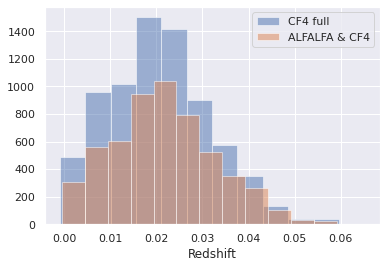

In [21]:
plt.hist(z_cf4, density=False, alpha=0.5,bins=12,label='CF4 full')
plt.hist(np.array(zhubble), density=False,bins=12, alpha=0.5,label='ALFALFA & CF4')
plt.legend()
plt.xlabel('Redshift')

(array([  15.,   36.,   68.,  144.,  377.,  900., 1537., 1560.,  833.,
          98.]),
 array([1.32221929, 1.47864644, 1.63507358, 1.79150072, 1.94792787,
        2.10435501, 2.26078215, 2.4172093 , 2.57363644, 2.73006358,
        2.88649073]),
 <BarContainer object of 10 artists>)

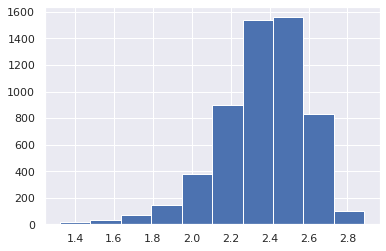

In [22]:
plt.hist(np.log10(W50))

(array([1752., 1998., 4156., 5543., 4847., 4952., 3621., 2697., 1212.,
         724.]),
 array([  0.3 ,  26.23,  52.16,  78.09, 104.02, 129.95, 155.88, 181.81,
        207.74, 233.67, 259.6 ]),
 <BarContainer object of 10 artists>)

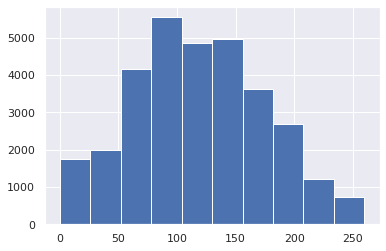

In [53]:
plt.hist(Dist)

# Velocity Width Function

The number density of galaxies $N$ with velocity widths $\omega$ is observed to follow the Schechter
function $\phi$:

\begin{align}\phi(\omega)  =
   {\rm ln}(10)\phi_*(\frac{\omega}{\omega_{*}})^{\alpha}
   {\rm exp}\left[-(\frac{\omega}{\omega_{*}})^{\beta}\right].\end{align}


# HI Mass Function

The number density of galaxies $N$ with HI masses $M_{HI}$ is widely observed to follow the modified Schechter
function $\phi$:


\begin{align}\phi(M_{HI}) =
   {\rm ln}(10)\phi_*(\frac{M_{HI}}{M_{*}})^{(\alpha+1)}
   {\rm exp}\left[-\frac{M_{HI}}{M_{*}}\right].\end{align}

In [23]:
PHI_STAR = 10**(-2.23)
LOG_M_STAR = 9.92
ALPHA = -1.29
#LOG_M_LIMIT = np.log10(20)
FLUX_LIMIT = 0.1
M_BW = 0.1

def phi_mass(log_m, log_m_star=LOG_M_STAR, alpha=ALPHA, phi_star=PHI_STAR):
    
    L = (10**log_m)/(10**log_m_star)
    phi_model_z = np.log10(10) * phi_star * L ** (alpha+1) * np.exp(-L)
    probability = phi_model_z
    
    return probability/np.sum(probability)

def phi_mass_limited(log_m, z, flux_limit=FLUX_LIMIT, m_bw = M_BW, log_m_star=LOG_M_STAR, alpha=ALPHA, phi_star=PHI_STAR):
    
    dist = z*c/70.0 # Mpc
    
    flux = (10**log_m) / (2.36 * 10**5 * dist**2)
    m_mask = np.logical_not(flux >= flux_limit)
    
    L = (10**log_m)/(10**log_m_star)
    phi_model_z = np.log10(10) * phi_star * L ** (alpha+1) * np.exp(-L)
    probability = phi_model_z
    probability = phi_model_z*m_mask
    nanmask = [~np.isnan(probability)]
    probability = probability[nanmask]

    if np.sum(probability) != 0:
        normal_c = np.sum(probability)
    else:
        normal_c = 1
    
    kde = gaussian_kde(M[nanmask], weights = probability/normal_c, bw_method = m_bw)  #tune `bw_method` to get the bandwidth you want
    
    probability = kde.pdf(M)
    return probability/np.sum(probability)


Text(0.5, 1.0, 'HI Mass Function')

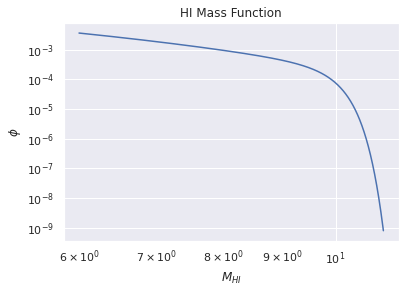

In [24]:
bins = np.linspace(6, 11, 1000) #abs magnitude bins 
#plt.plot(bins, log_phi(bins))
plt.plot(bins, phi_mass(bins))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$M_{HI}$')
plt.ylabel('$\phi$')
plt.title('HI Mass Function')

In [25]:
PHI_STAR = 10**(-1.67)
W_STAR = 307
ALPHA = -0.63
BETA = 2.0
LOG_W_LIMIT = np.log10(20)


def completeness_func(log_w):
    S_50 = []
    for i in range(len(log_w)):
        if log_w[i] < 2.5:
            S_90 = 0.5*log_w[i] - 1.11
        else:
            S_90 = log_w[i] - 2.36
    
        S_50.append(S_90 - 0.13)
    
    return np.array(S_50)

def phi_width(w, w_star=W_STAR, alpha=ALPHA, beta=BETA, phi_star=PHI_STAR):
    
    L = ((w)/(w_star))**beta
    phi_model_z =  np.log(10) * phi_star * ((w/W_STAR)**alpha) * np.exp(-L)
    probability = phi_model_z
    
    return probability/np.sum(probability)

def mass_cond_width(w, m, zmin=np.log10(15), zmax=10**3):
    
    if m<= 9.83:
        beta = -0.0158 * m + 0.316
        
    else:
        beta = -0.0578 * m + 0.729
    
    mu = 0.322 * m - 0.728
    
    z = (mu - w) / beta
    
    probability = (1/beta) * (np.exp(-(z+np.exp(-z)))/(np.exp(-np.exp(-zmax))-np.exp(-np.exp(-zmin))))

    return probability/np.sum(probability)


def mass_cond_width_lim(w, m, z, zmin=np.log10(15), zmax=10**3):
    
    dist = z*c/70.0 # Mpc
    flux = (10**m) / (2.36 * 10**5 * dist**2)
    s_50 = completeness_func(w)

    mask = np.logical_not(s_50 >= flux)
    
    if m<= 9.83:
        beta = -0.0158 * m + 0.316
        
    else:
        beta = -0.0578 * m + 0.729
    
    mu = 0.322 * m - 0.728
    
    z = (mu - w) / beta
    
    probability = (1/beta) * (np.exp(-(z+np.exp(-z)))/(np.exp(-np.exp(-zmax))-np.exp(-np.exp(-zmin))))

    probability = probability*mask
    nanmask = [~np.isnan(probability)]
    probability = probability[nanmask]

    if np.sum(probability) != 0:
        normal_c = np.sum(probability)
    else:
        normal_c = 1
    
    kde = gaussian_kde(w[nanmask], weights = probability/normal_c, bw_method = 0.1)  #tune `bw_method` to get the bandwidth you want
    
    probability = kde.pdf(w)
    return probability/np.sum(probability)



Text(0.5, 1.0, 'Mass-conditional velocity width function')

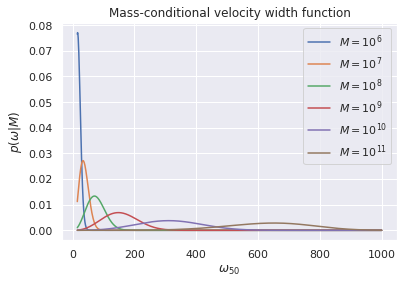

In [26]:
bins = np.linspace(15, 10**3, 1000) #velocity bins km/s
M_range = [6, 7, 8, 9, 10, 11]
M_label = ['$M=10^{6}$', '$M=10^{7}$', '$M=10^{8}$', '$M=10^{9}$', '$M=10^{10}$', '$M=10^{11}$']
           
for i in range(len(M_range)):
    plt.plot(bins, mass_cond_width(np.log10(bins), M_range[i]), label=M_label[i])

#plt.plot(bins, np.log10(log_phi_limited(bins)))
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$\omega_{50}$')
plt.ylabel('$p(\omega|M)$')
plt.title('Mass-conditional velocity width function')

<ipython-input-25-d349d42cb1ed>:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probability = probability[nanmask]
<ipython-input-25-d349d42cb1ed>:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  kde = gaussian_kde(w[nanmask], weights = probability/normal_c, bw_method = 0.1)  #tune `bw_method` to get the bandwidth you want
<ipython-input-25-d349d42cb1ed>:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arr

Text(0.5, 1.0, 'Mass-conditional velocity width function')

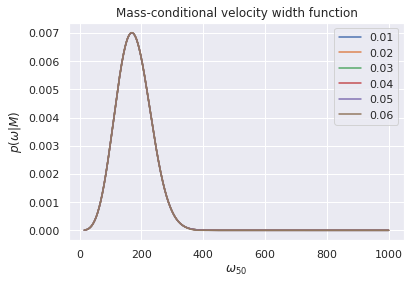

In [27]:
bins = np.linspace(15, 10**3, 1000) #velocity bins km/s
M_range = [6, 7, 8, 9, 10, 11]
z_range = [0.01,0.02,0.03,0.04,0.05,0.06]
z_label = ['0.01','0.02','0.03','0.04','0.05','0.06']
M_label = ['$M=10^{6}$', '$M=10^{7}$', '$M=10^{8}$', '$M=10^{9}$', '$M=10^{10}$', '$M=10^{11}$']
           
for i in range(len(z_range)):
    plt.plot(bins, mass_cond_width_lim(np.log10(bins), 9, z_range[i]), label=z_label[i])

#plt.plot(bins, np.log10(log_phi_limited(bins)))
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$\omega_{50}$')
plt.ylabel('$p(\omega|M)$')
plt.title('Mass-conditional velocity width function')

Text(0.5, 1.0, 'Velocity Width Function')

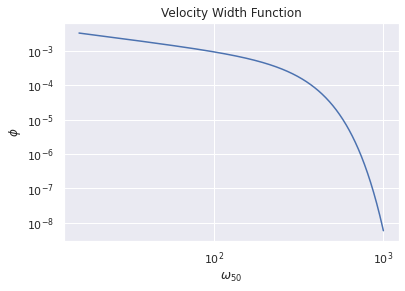

In [26]:
bins = np.linspace(1.2, 3.0, 1000) #abs magnitude bins 
plt.plot(10**bins, phi_width(10**bins))
#plt.plot(bins, np.log10(log_phi_limited(bins)))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\omega_{50}$')
plt.ylabel('$\phi$')
plt.title('Velocity Width Function')

-8.291786428882679 -20.769476437502327
-8.32 -20.8


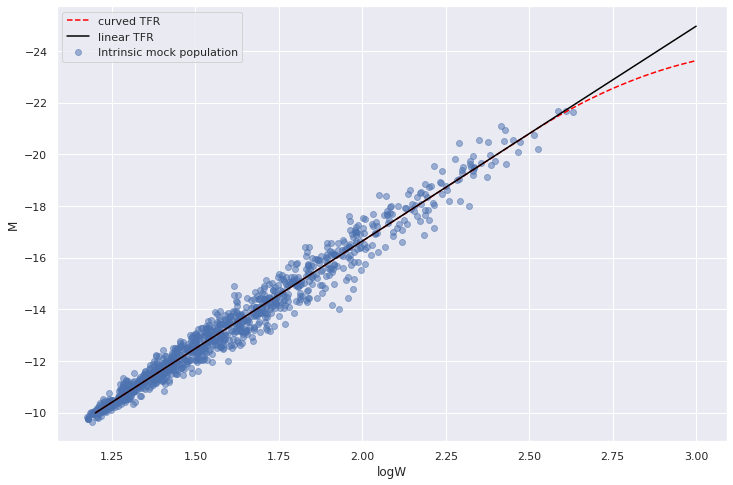

In [38]:
y_bins = np.linspace(-24, -13.5, 10000) #abs magnitude bins
x_bins = np.linspace(1.2, 3, 10000)-2.5 #logW bins
m_bins = np.linspace(6,11,10000) #HI mass in solar mass units
v_bins = np.linspace(15, 10**3, 10000) #velocity bins km/s

from scipy.stats import linregress


prob = phi_mass(m_bins)
m_sel = m_bins[np.random.choice(np.arange(len(m_bins)), size=1000, p=prob)]
v_sel = []
for i in range(len(m_sel)):
    prob = mass_cond_width(np.log10(v_bins), m_sel[i])
    v_width = float(np.random.choice(v_bins, p=prob))
    #s_50 = completeness_func(np.log10(v_width) - 2.5)
    
    v_sel.append(v_width)
    
x_sel = np.log10(np.array(v_sel))-2.5

xinv, yinv = x_sel, curved_TFR(x_sel)

yerr = []
for i in range(len(yinv)):
    yerr.append(np.random.normal(loc = 0, scale = RMS_scatter(yinv[i]), size = None))
dy = np.array(yerr)
yinv = yinv + dy

plt.figure(figsize=(12, 8))
plt.scatter(xinv+2.5,yinv, label='Intrinsic mock population',alpha=0.5)
plt.plot(x_bins+2.5, curved_TFR(x_bins), label='curved TFR',color='red', linestyle='dashed')
plt.plot(x_bins+2.5, linear_TFR(x_bins), label='linear TFR',color='black')

plt.gca().invert_yaxis()
plt.xlabel('logW')
plt.ylabel('M')
#plt.axhline(linestyle='dashed',y=M_LIMIT_ABSOLUTE,label='i-band magnitude limit',color='black')
plt.legend()
### 
print(linregress(np.array(xinv),np.array(yinv)).slope, linregress(np.array(xinv),np.array(yinv)).intercept)
print(a_TF,b_TF)

<Figure size 864x576 with 0 Axes>

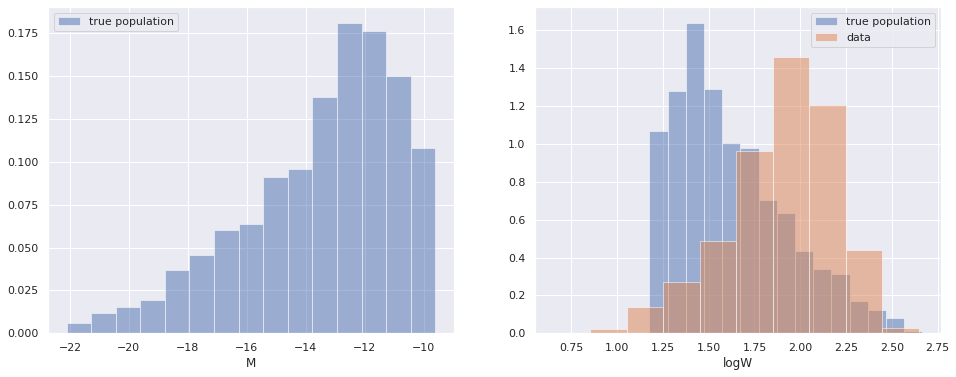

In [38]:
plt.figure(figsize=(12, 8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.hist(yinv, alpha=0.5,bins=15, label='true population', density=True)
ax1.set_xlabel('M')
ax1.legend()

ax2.hist(xinv+2.5, alpha=0.5,bins=15, label='true population', density=True)
ax2.set_xlabel('logW')
ax2.hist(np.log10(W50/2), label='data',alpha=0.5, density=True)
ax2.legend()



## Generate ALFALFA-like samples

In [28]:
def sample_ALFALFA_positions(N=200, save_to_file=False, seed=None):

    data = alfalfa_pred
    m_samp = []
    
    N_CF4 = data.shape[0]
    RA = data[:,0] # degrees
    DEC = data[:,1] # degrees
    vext_r = data[:,2]
    PV_norm = data[:,3]
    PV = data[:,4]
    co_dist = data[:,5]
    zobs = data[:,6]
    zhubble = data[:,7]
    W50 = data[:,8]

    np.random.seed(seed)
    #zobs = np.random.uniform(low=0.002, high=0.01, size=N_SFI)
    #zobs = np.random.normal(loc=np.mean(zobs)*0.1, scale=np.std(zobs)*0.5, size=N_SFI)
    zhubble = (1+zobs)/(1+(PV/c)) - 1
    inds = np.random.choice(np.arange(N_CF4), size=N, replace=False)
    #inds = np.arange(N)
    
    RA, DEC, vext_r, PV_norm, zobs, zhubble, co_dist, W50 = RA[inds], DEC[inds], vext_r[inds], PV_norm[inds], zobs[inds], zhubble[inds], co_dist[inds], W50[inds]
    
    return RA, DEC, vext_r, PV_norm, zobs, zhubble, co_dist, W50

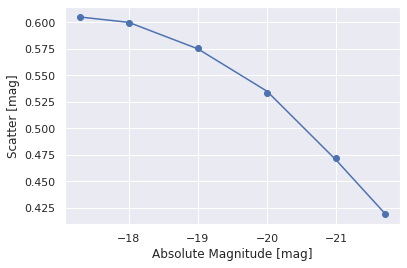

In [30]:
Mags = np.array([-17.3,-18,-19,-20,-21,-21.7])
rms = np.array([0.605,0.6,0.575,0.535,0.47,0.42])

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

FIT_PARAMS, pcov = curve_fit(parabola, Mags, rms)
y_fit = parabola(Mags, *FIT_PARAMS)
plt.plot(Mags,rms)
plt.ylabel('Scatter [mag]')
plt.xlabel('Absolute Magnitude [mag]')

plt.scatter(Mags, y_fit)
plt.gca().invert_xaxis()

def RMS_scatter(y):
    # return magnitude-depedent scatter as per CF4
    return parabola(y, *FIT_PARAMS)

In [75]:
FIT_PARAMS

array([-0.00923175, -0.31766776, -2.12739389])

In [31]:
# Define curved TFR in the i-band
a2_TF = 5.34 #+/- 0.91

def linear_TFR(x, a=a_TF, b=b_TF, a2=a2_TF):
    linear_TFR = a*x + b

    return linear_TFR 

def curved_TFR(x, a=a_TF, b=b_TF, a2=a2_TF):
    linear_TFR = a*x + b
    
    curvature = a2 * x**2 
    curvature_mask = np.logical_not(x<=0)
        
    return linear_TFR + curvature*curvature_mask

def linear_ITFR(y, a=a_TF, b=b_TF, a2=a2_TF):
    linear_ITFR = (y-b)/a

    return linear_ITFR 

def curved_ITFR(y, a=a_TF, b=b_TF, a2=a2_TF):
    linear_ITFR = (y-b)/a
    curvature_mask = np.logical_not(linear_ITFR<=0)

    curvature = (- a - np.sqrt(a**2 - 4*a2*(b-y)))/(2*a2) - linear_ITFR
        
    return linear_ITFR + curvature*curvature_mask

Text(0, 0.5, 'logW')

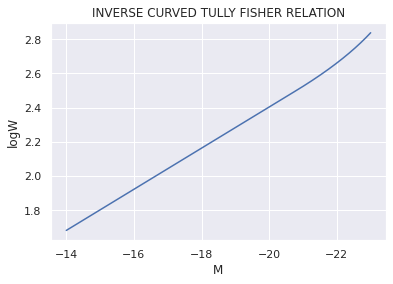

In [58]:
bins = np.linspace(-23, -14, 10000) #abs magnitude bins
plt.plot(bins, curved_ITFR(bins)+2.5)
plt.gca().invert_xaxis()
plt.title('INVERSE CURVED TULLY FISHER RELATION')
plt.xlabel('M')
plt.ylabel('logW')

Text(0, 0.5, 'M')

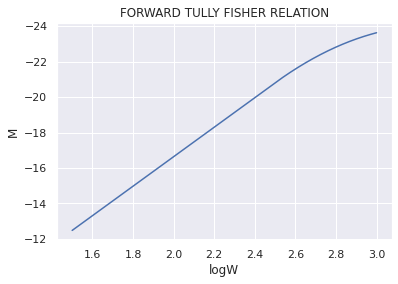

In [36]:
bins = np.linspace(1.5, 3, 10000) #logW bins
plt.plot(bins, curved_TFR(bins-2.5))
#plt.xlim(1.0,3.1)
plt.gca().invert_yaxis()
plt.title('FORWARD TULLY FISHER RELATION')
plt.xlabel('logW')
plt.ylabel('M')

$W_{v}$ = Intrinsic rotational velocity width

$W_{m50}$ = Measured HI line width at 50% average HI flux

## Sampling procedure 

1.	Generate a set of redshifts by bootstrapping off of the ALFALFA survey redshift distribution, using only the ALFALFA galaxies present in the CF4 sample. 
 
2.	For each galaxy redshift, compute the HI mass corresponding to the low-end flux limit using: 

$\frac{M_{HI}}{M_{sun}} = 2.36 \times 10^{5} (D_{L}/\textrm{Mpc})^{2}(S_{21}/\textrm{Jy km s}^{-1})$,

where $D_{L}$ is the luminosity distance.

3. We assign an HI mass to each galaxy by sampling from the HI mass function:

$\phi(M_{HI}) =
   {\rm ln}(10)\phi_*(\frac{M_{HI}}{M_{*}})^{(\alpha+1)}
   {\rm exp}\left[-\frac{M_{HI}}{M_{*}}\right]$
   
   truncated at the HI mass corresponding to the flux limit.

4.	For each galaxy, given its HI mass, sample a line width $W_{m50}$ from the appropriate conditional velocity width distribution. For this we assume a Gumbel distribution, with parameters determined in a previous ALFALFA analysis.

5.	These steps leave us with the intrinsic source list. All galaxies in this list below the ALFALFA 50% completeness limit are removed to yield the observed source list. The completeness function depends on both linewidth width $W_{m50}$ and HI mass $M_{HI}$.
 
6. Observed linewidths at 50% average HI flux $W_{m50}$ are corrected for spectral resolution and redshift:

$W_{m50}^{c} = \frac{W_{m50}}{1+z} - 2\lambda\Delta\nu$

7. Linewidths are further adjusted to approximate twice (projected) maximum rotation, $W_{mx}$:

$W_{mx} = W_{m50}^{c} - 6$
 

8.	Pick a random inclination $i$ from the list of CF4 inclinations. De-project each $W_{mx}$ for the inclination $i$ to compute a $W_{v}$.
 
 $W_{v} = W_{mx} / \text{sin}(i) $

9.	Use the Tully-Fisher relation, along with its intrinsic scatter model, to assign an absolute magnitude to each intrinsic velocity width $W_{v}$.

10.	Calculate the apparent magnitude from the absolute magnitude and galaxy redshift.



In [32]:
class TF_mock:

    def __init__(self, inclinations=cf4_incl, vext=vext_true, beta=beta_true,a2=a2_TF, a=a_TF, b=b_TF,log_m_star=LOG_M_STAR, alpha=ALPHA, phi_star=PHI_STAR, seed=None):
        self.inclinations = inclinations
        
        #   Tully Fisher
        self.a = a_TF
        self.b = b_TF
        self.a2 = a2_TF
        
        # HI mass Function
        self.log_m_star = log_m_star
        self.alpha = alpha
        self.phi_star = phi_star

        # Peculiar Velocity
        self.beta = beta
        self.vext = vext
        
        #   Cosmological
        self.Om0 = Om0
        self.Ol0 = 1.0 - self.Om0
        self.h = h
        self.H0 = 100.0 # [h km/s/Mpc]
        self.sigma80 = sigma80
        self.dH = c/self.H0 * 1e3 # c/H_0 [h^-1 kpc]
        self.q0 = 0.5*self.Om0 - self.Ol0

        self.seed = seed # None is random state
        self.y_bins = np.linspace(-24, -13.5, 10000) #abs magnitude bins
        self.x_bins = np.linspace(1.5, 3, 10000)-2.5 #logW bins
        
        self.m_bins = np.linspace(6,11,10000) #HI mass in solar mass units
        self.v_bins = np.linspace(15, 10**3, 10000) #velocity bins km/s


    def RMS_scatter(self, y):
        # return magnitude-depedent scatter as per CF4
        return parabola(y, *FIT_PARAMS)
    

    def _x_y_scattered(self, W50, zhubble):
        samp_size = len(zhubble)
        
        lw_corr = np.array(W50)/(1+np.array(zhubble)) - 6
        incl = np.random.choice(self.inclinations, replace=True, size=samp_size)
        v_sel = lw_corr/np.sin(incl)
        x_sel = np.log10(v_sel)-2.5

        xinv_lim, yinv_lim = x_sel, curved_TFR(x_sel)

        yerr = []
        for i in range(len(yinv_lim)):
            yerr.append(np.random.normal(loc = 0, scale = self.RMS_scatter(yinv_lim[i]), size = None))
        dy = np.array(yerr)
        yinv_lim = yinv_lim + dy
        
        return xinv_lim, yinv_lim
    
    def _x_y_scattered_app(self, zhubble):
        
        z_inds = np.random.choice(np.arange(len(zhubble)), size=len(self.y_bins), replace=True)        
        samp_size = len(zhubble)
        zz = np.array(zhubble)[z_inds]

        prob = phi_mass(self.m_bins, log_m_star=self.log_m_star, alpha=self.alpha, phi_star=self.phi_star)
        inds = np.random.choice(np.arange(len(self.m_bins)), size=samp_size, p=prob)
        m_sel = self.m_bins[inds]
        lw_sel = []
        for i in range(len(m_sel)):
            prob = mass_cond_width_lim(np.log10(self.v_bins), m_sel[i], zz[i])
            v_width = float(np.random.choice(self.v_bins, p=prob))
            lw_sel.append(v_width)
        
        #lw_corr = np.array(lw_sel)/(1+zz) - 6
        lw_corr = np.array(lw_sel) + 50
        incl = np.random.choice(self.inclinations, replace=True, size=samp_size)
        v_sel = lw_corr/np.sin(incl)

        x_sel = np.log10(v_sel)-2.5

        xinv_lim, yinv_lim = x_sel, curved_TFR(x_sel)

        yerr = []
        for i in range(len(yinv_lim)):
            yerr.append(np.random.normal(loc = 0, scale = self.RMS_scatter(yinv_lim[i]), size = None))
        dy = np.array(yerr)
        yinv_lim = yinv_lim + dy
        
        return xinv_lim, yinv_lim, z_inds, inds
    
    def add_noise(self, ylatent, percentage_err):
        
        y_err = np.absolute(ylatent * (percentage_err/100.0))
        np.random.seed(self.seed)
        dy = np.array([norm.rvs(loc=0, scale=std) for std in abs(y_err)])
        yhat = ylatent + dy
        Eyy = y_err**2
        
        return yhat, Eyy
    
    def _get_app_mag(self, M, dL):
        m = []
        for i in range(len(M)):
            mu = 5 * np.log10(dL[i]*1e5) #convert dL to pc
            m.append(M[i]+mu)
        return np.array(m)
    
    def _get_luminosity_distance(self, z):
        """
        Computes the luminosity distance in units MPc
        """
        chi = []
        for i in range(len(z)):
            chi.append(cosmo.luminosity_distance(z[i]).value)
        return np.array(chi)
    
    def _get_comoving_distance(self, z):
        """
        Computes the comoving distance in units MPc
        """
        chi = []
        for i in range(len(z)):
            chi.append(cosmo.comoving_distance(z[i]).value)
        return np.array(chi)
    
    def init_ALFALFA_like_data(self, N=500, add_pv=True, y_percentage_err=0.0, scale=1.0):
        
        np.random.seed(self.seed)
        self.N = N
        self.RA, self.DEC, self.vext_r, self.V_samp_norm, self.zobs, self.zhubble, self.co_dist, self.W50 = sample_ALFALFA_positions(self.N, seed=self.seed)
        
        # sampling from Schechter LF (C)

        #self.xlatent, self.ylatent, inds1, inds2 = self._x_y_scattered_app(self.zhubble) # sample from Schechter
        self.xlatent, self.ylatent = self._x_y_scattered(self.W50, self.zhubble)
        #self.RA, self.DEC, self.vext_r, self.V_samp_norm, self.zobs, self.zhubble, self.co_dist = self.RA[inds1][inds2], self.DEC[inds1][inds2], self.vext_r[inds1][inds2], self.V_samp_norm[inds1][inds2], self.zobs[inds1][inds2], self.zhubble[inds1][inds2], self.co_dist[inds1][inds2]

        self.wlatent, self.mlatent = 10**(self.xlatent+2.5), self.ylatent
        
        median_e_logW = 0.02#np.median(self.e_logW) # assuming gaussian err in logW
        median_e_IMAG = 0#np.median(self.e_IMAG) # assuming gaussian err in IMAG
        
        self.x_percent_err = 100 * np.absolute(median_e_logW/self.xlatent)
        self.y_percent_err = 100 * np.absolute(median_e_IMAG/self.ylatent)
        
        self.w_percent_err = 100 * np.absolute(np.log(10) * (10**median_e_logW) * median_e_logW / self.wlatent)
        self.m_percent_err = 100 * np.absolute(median_e_IMAG/self.mlatent)
        
        #self.yhat, self.Eyy = self.add_noise(self.ylatent, self.y_percent_err)
        #self.xhat, self.Exx = self.add_noise(self.xlatent, self.x_percent_err)
                
        #self.what, self.Eww = self.add_noise(self.wlatent, self.w_percent_err)
        #self.mhat, self.Emm = self.add_noise(self.mlatent, self.m_percent_err)
                
        self.V_samp = self.V_samp_norm*self.beta + self.vext_r
        if add_pv == False:
            self.V_samp = np.zeros(self.N)
        self.alpha = self.RA * np.pi/180
        self.delta = self.DEC * np.pi/180
        
        self.zobs = (self.co_dist*100 + (self.V_samp_norm*beta_true + self.vext_r))/c ## somehow this fixes the vext estimate
        #self.zhubble = (1+self.zobs)/(1+(self.V_samp/c)) - 1 ## but this can't be updated??

        self.lumin_dist = self._get_luminosity_distance(self.zhubble)
        self.co_dist = self._get_comoving_distance(self.zhubble)
        
        self.absmag = self.mlatent
        self.appmag = self._get_app_mag(self.absmag, self.lumin_dist)
        self.sigma = self.RMS_scatter(self.ylatent)
        
    def data_dict(self): 
        return {'z': self.zobs, 'zhubble' : self.zhubble, 'vext':self.vext_r, 'dL':self.lumin_dist, 'pv_norm':self.V_samp_norm, 
                'pv':self.V_samp, 'RA': self.RA, 'DEC': self.DEC, 'r':self.co_dist,
                 'mc': self.appmag, 'Mc':self.absmag,
                 'xc': self.xlatent, 'yc':self.ylatent,'sigc':self.sigma}

In [67]:
mock = TF_mock() # new values from qin
mock.init_ALFALFA_like_data(N=5000, y_percentage_err = 0.0)

<ipython-input-32-0ce1884d9e4d>:105: RuntimeWarning: invalid value encountered in log10
  mu = 5 * np.log10(dL[i]*1e5) #convert dL to pc


In [34]:
logW_cf4 = np.load('cf4_data.npy')[0]
LW_cf4 = np.load('cf4_data.npy')[2]
z_cf4 = np.load('cf4_data.npy')[3]/c
Imag_cf4_corr_dust = np.load('cf4_data.npy')[4]
cf4_incl = np.deg2rad(np.load('cf4_data.npy')[1])
VW_cf4 = LW_cf4/np.sin(cf4_incl)

In [43]:
W50_alf = np.load('alfalfa_data.npy')[1]
z_alf = np.load('alfalfa_data.npy')[2]/c


In [44]:
cf4_corr_LW = []

for i in range(len(z_alf)):
    ind = np.where(z_cf4 == z_alf[i])[0]
    if len(ind)==1:
        cf4_corr_LW.append(LW_cf4[ind])
    else:
        cf4_corr_LW.append(0)

cf4_corr_LW = np.array(cf4_corr_LW)

<ipython-input-44-660975e2d41b>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cf4_corr_LW = np.array(cf4_corr_LW)


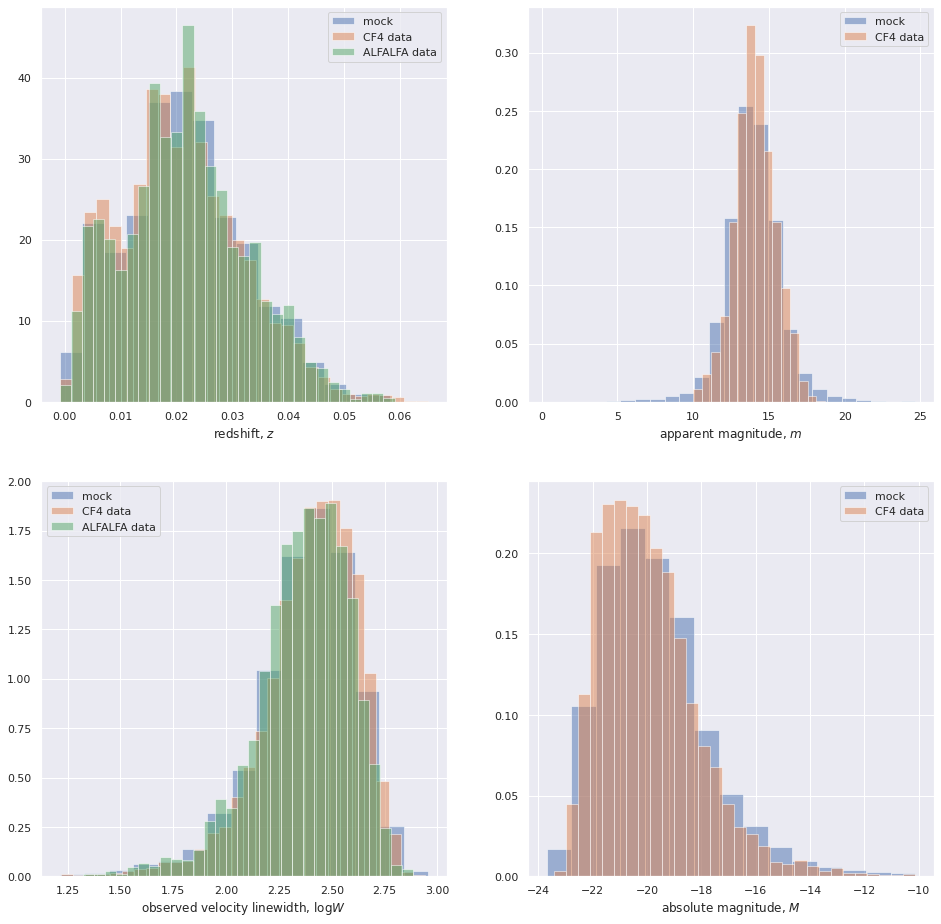

In [68]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
#fig.suptitle('Histograms of Mock ALFALFA observables')

ax1.hist(mock.data_dict()['z'], bins=15, alpha=0.5, label='mock', density=True)
ax1.hist(np.array(z_cf4), alpha=0.5,bins=30, label='CF4 data', density=True)
ax1.hist(np.array(zobs), alpha=0.5,bins=30, label='ALFALFA data', density=True)

ax1.set(xlabel='redshift, $z$')
ax1.legend()
ax2.hist(mock.data_dict()['mc'], alpha=0.5,bins=25, label='mock', density=True)
ax2.hist(Imag_cf4_corr_dust,  alpha=0.5,bins=15, label='CF4 data', density=True)

ax2.set(xlabel='apparent magnitude, $m$')
ax2.legend()

ax3.hist((mock.data_dict()['xc']+2.5), alpha=0.5, bins=15, label='mock', density=True)
ax3.hist((logW_cf4), bins=30, alpha=0.5, label='CF4 data', density=True)
ax3.hist((np.log10(W50)), bins=30, alpha=0.5, label='ALFALFA data', density=True)

ax3.set(xlabel='observed velocity linewidth, log$W$')
ax3.legend()
ax4.hist(mock.data_dict()['Mc'], alpha=0.5,bins=15, label='mock', density=True)
absMag = curved_TFR((logW_cf4-2.5))
ax4.hist(np.array(absMag),  alpha=0.5,bins=30, label='CF4 data', density=True)

ax4.set(xlabel='absolute magnitude, $M$')
ax4.legend()

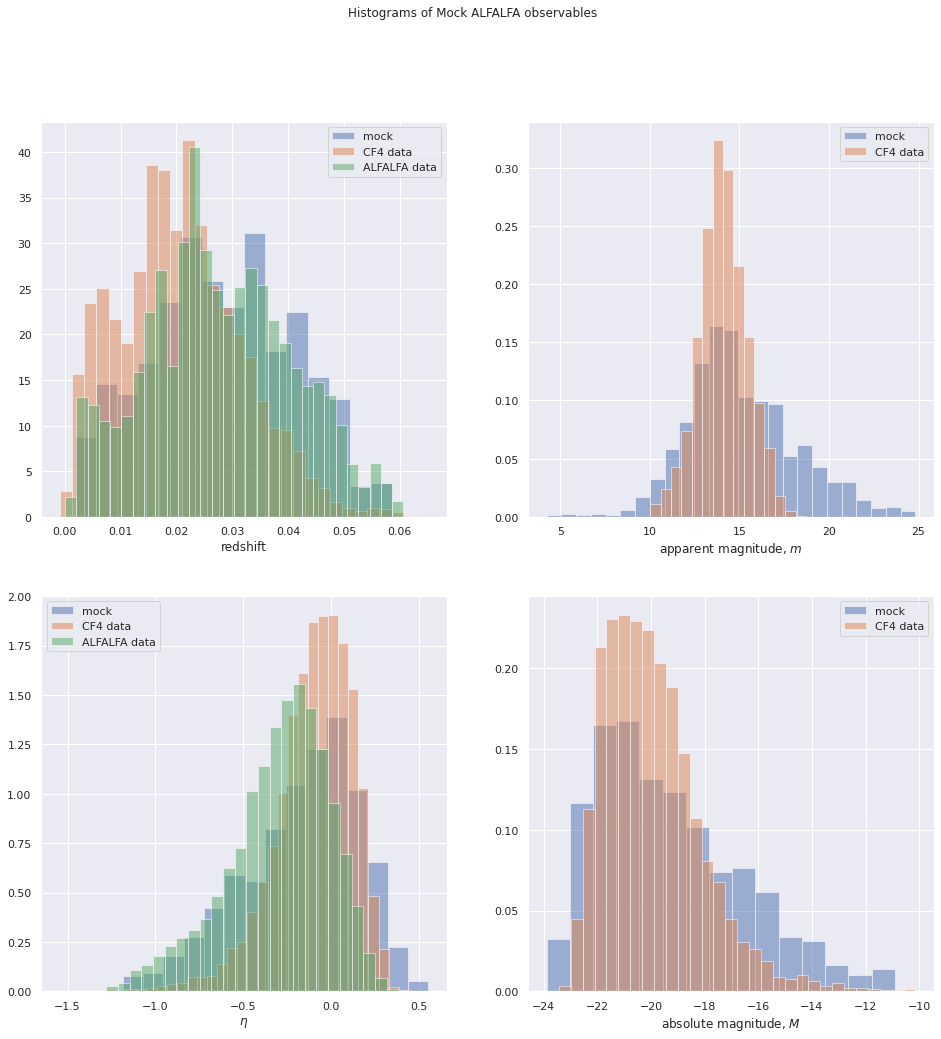

In [132]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Histograms of Mock ALFALFA observables')

ax1.hist(mock.data_dict()['z'], bins=15, alpha=0.5, label='mock', density=True)
ax1.hist(np.array(z_cf4), alpha=0.5,bins=30, label='CF4 data', density=True)
ax1.hist(np.array(zobs), alpha=0.5,bins=30, label='ALFALFA data', density=True)

ax1.set(xlabel='redshift')
ax1.legend()
ax2.hist(mock.data_dict()['mc'], alpha=0.5,bins=25, label='mock', density=True)
ax2.hist(Imag_cf4_corr_dust,  alpha=0.5,bins=15, label='CF4 data', density=True)

ax2.set(xlabel='apparent magnitude, $m$')
ax2.legend()

ax3.hist((mock.data_dict()['xc']), alpha=0.5, bins=15, label='mock', density=True)
ax3.hist((logW_cf4-2.5), bins=30, alpha=0.5, label='CF4 data', density=True)
ax3.hist((np.log10(W50)-2.5), bins=30, alpha=0.5, label='ALFALFA data', density=True)

ax3.set(xlabel='$\eta$')
ax3.legend()
ax4.hist(mock.data_dict()['Mc'], alpha=0.5,bins=15, label='mock', density=True)
absMag = curved_TFR((logW_cf4-2.5))
ax4.hist(np.array(absMag),  alpha=0.5,bins=30, label='CF4 data', density=True)

ax4.set(xlabel='absolute magnitude, $M$')
ax4.legend()

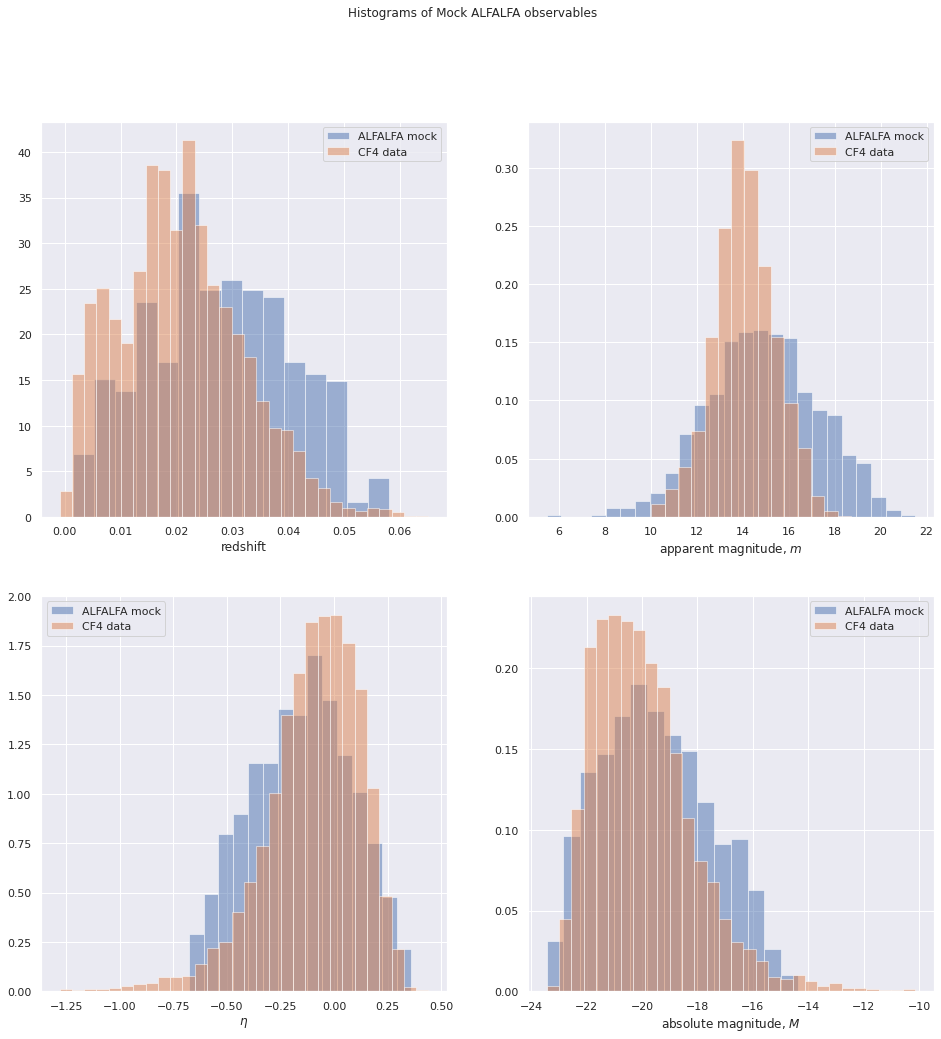

In [194]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Histograms of Mock ALFALFA observables')

ax1.hist(mock.data_dict()['z'], bins=15, alpha=0.5, label='ALFALFA mock', density=True)
ax1.hist(np.array(z_cf4), alpha=0.5,bins=30, label='CF4 data', density=True)
#ax1.hist(np.array(zobs), alpha=0.5,bins=30, label='ALFALFA data', density=True)

ax1.set(xlabel='redshift')
ax1.legend()
ax2.hist(mock.data_dict()['mc'], alpha=0.5,bins=25, label='ALFALFA mock', density=True)
ax2.hist(Imag_cf4_corr_dust,  alpha=0.5,bins=15, label='CF4 data', density=True)

ax2.set(xlabel='apparent magnitude, $m$')
ax2.legend()

ax3.hist((mock.data_dict()['xc']), alpha=0.5, bins=15, label='ALFALFA mock', density=True)
ax3.hist((logW_cf4-2.5), bins=30, alpha=0.5, label='CF4 data', density=True)
#ax3.hist((np.log10(W50)-2.5), bins=30, alpha=0.5, label='ALFALFA data', density=True)

ax3.set(xlabel='$\eta$')
ax3.legend()
ax4.hist(mock.data_dict()['Mc'], alpha=0.5,bins=15, label='ALFALFA mock', density=True)
absMag = curved_TFR((logW_cf4-2.5))
ax4.hist(np.array(absMag),  alpha=0.5,bins=30, label='CF4 data', density=True)

ax4.set(xlabel='absolute magnitude, $M$')
ax4.legend()

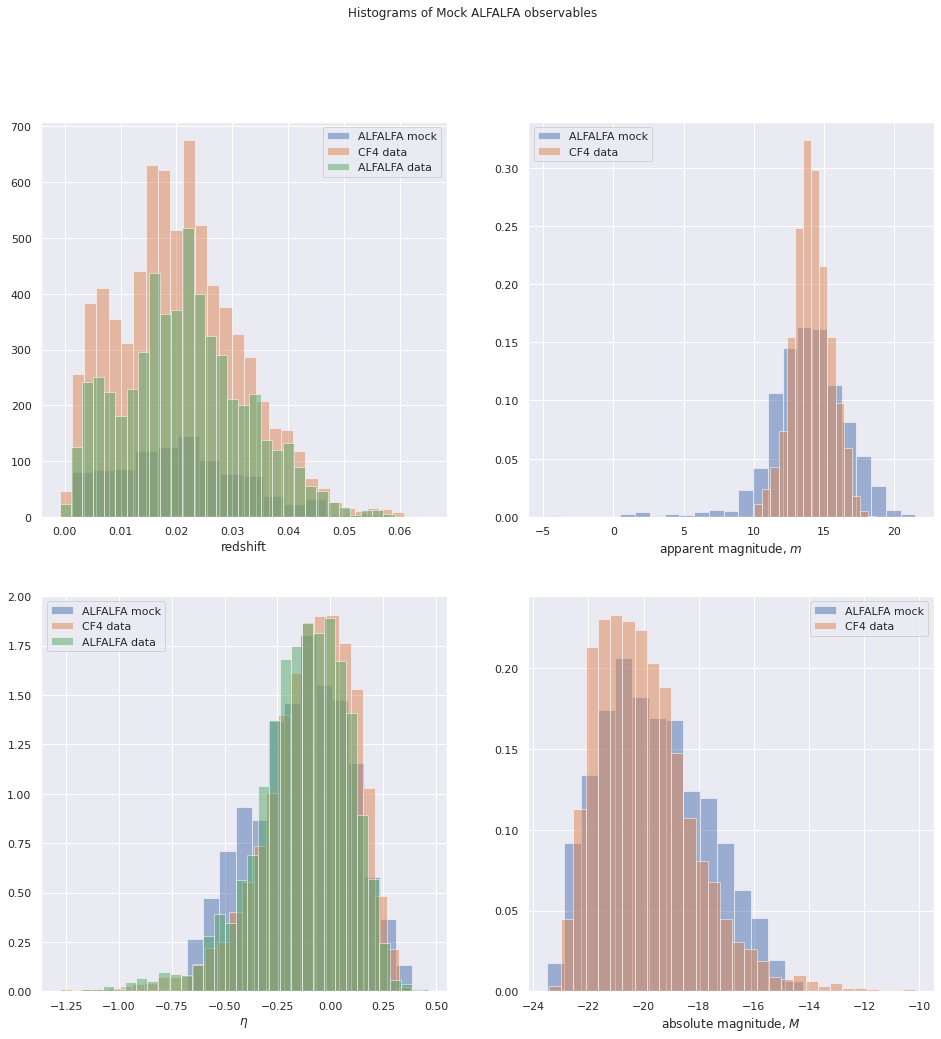

In [96]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Histograms of Mock ALFALFA observables')

ax1.hist(mock.data_dict()['z'], bins=15, alpha=0.5, label='ALFALFA mock', density=False)
ax1.hist(np.array(z_cf4), alpha=0.5,bins=30, label='CF4 data', density=False)
ax1.hist(np.array(z_alf), alpha=0.5,bins=30, label='ALFALFA data', density=False)

ax1.set(xlabel='redshift')
ax1.legend()
ax2.hist(mock.data_dict()['mc'], alpha=0.5,bins=25, label='ALFALFA mock', density=True)
ax2.hist(Imag_cf4_corr_dust,  alpha=0.5,bins=15, label='CF4 data', density=True)

ax2.set(xlabel='apparent magnitude, $m$')
ax2.legend()

ax3.hist((mock.data_dict()['xc']), alpha=0.5, bins=15, label='ALFALFA mock', density=True)
ax3.hist((logW_cf4-2.5), bins=30, alpha=0.5, label='CF4 data', density=True)
ax3.hist((np.log10(W50_alf)-2.5), bins=30, alpha=0.5, label='ALFALFA data', density=True)

ax3.set(xlabel='$\eta$')
ax3.legend()
ax4.hist(mock.data_dict()['Mc'], alpha=0.5,bins=15, label='ALFALFA mock', density=True)
absMag = curved_TFR((logW_cf4-2.5))
ax4.hist(np.array(absMag),  alpha=0.5,bins=30, label='CF4 data', density=True)

ax4.set(xlabel='absolute magnitude, $M$')
ax4.legend()

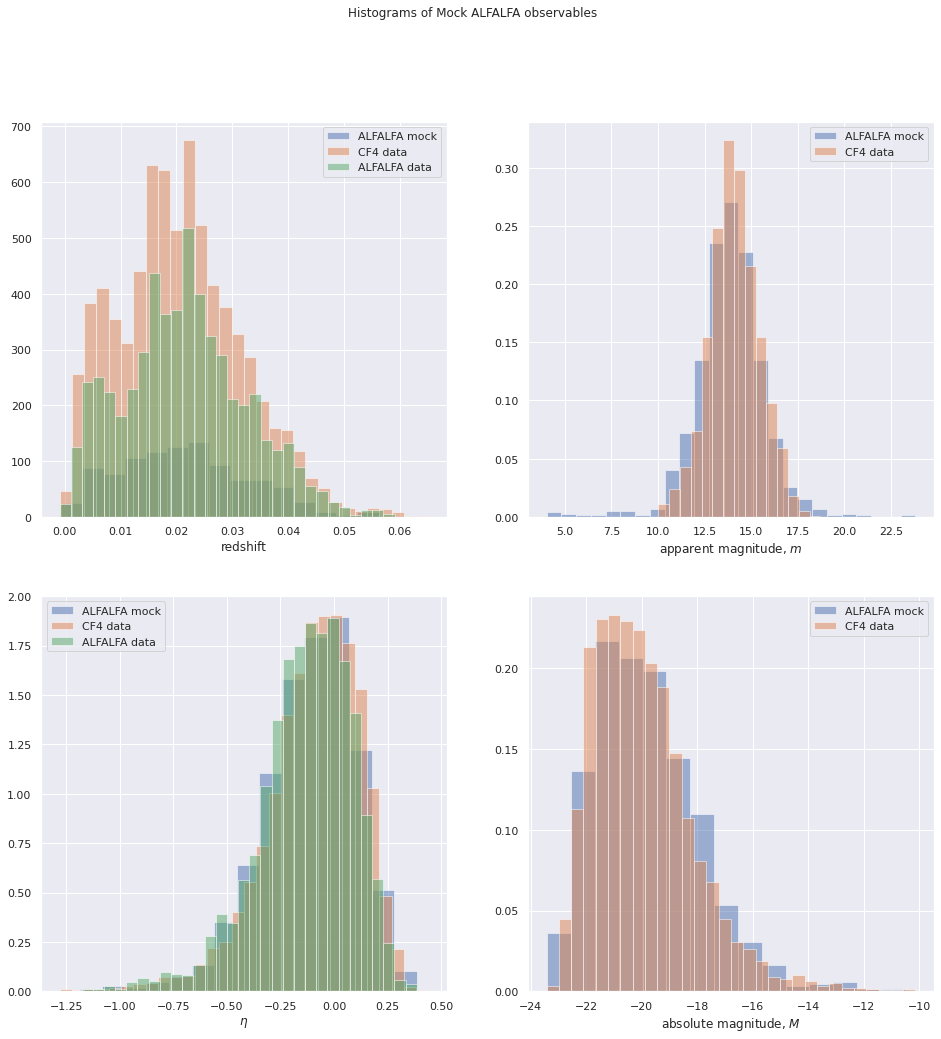

In [112]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Histograms of Mock ALFALFA observables')

ax1.hist(mock.data_dict()['z'], bins=15, alpha=0.5, label='ALFALFA mock', density=False)
ax1.hist(np.array(z_cf4), alpha=0.5,bins=30, label='CF4 data', density=False)
ax1.hist(np.array(z_alf), alpha=0.5,bins=30, label='ALFALFA data', density=False)

ax1.set(xlabel='redshift')
ax1.legend()
ax2.hist(mock.data_dict()['mc'], alpha=0.5,bins=25, label='ALFALFA mock', density=True)
ax2.hist(Imag_cf4_corr_dust,  alpha=0.5,bins=15, label='CF4 data', density=True)

ax2.set(xlabel='apparent magnitude, $m$')
ax2.legend()

ax3.hist((mock.data_dict()['xc']), alpha=0.5, bins=15, label='ALFALFA mock', density=True)
ax3.hist((logW_cf4-2.5), bins=30, alpha=0.5, label='CF4 data', density=True)
ax3.hist((np.log10(W50_alf)-2.5), bins=30, alpha=0.5, label='ALFALFA data', density=True)

ax3.set(xlabel='$\eta$')
ax3.legend()
ax4.hist(mock.data_dict()['Mc'], alpha=0.5,bins=15, label='ALFALFA mock', density=True)
absMag = curved_TFR((logW_cf4-2.5))
ax4.hist(np.array(absMag),  alpha=0.5,bins=30, label='CF4 data', density=True)

ax4.set(xlabel='absolute magnitude, $M$')
ax4.legend()

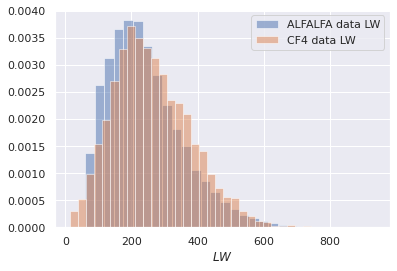

In [190]:
#inclinations = np.random.choice(cf4_incl,replace=True,size=len(W50))
plt.hist((W50)+50, bins=30, alpha=0.5, label='ALFALFA data LW', density=True)
plt.hist((LW_cf4), bins=30, alpha=0.5, label='CF4 data LW', density=True)
#plt.hist((10**logW_cf4), bins=30, alpha=0.5, label='CF4 data VW', density=True)

plt.xlabel('$LW$')
plt.legend()

In [50]:
def linewidth_corr(Wl, Wcl=100, Wtl=9):
    Wrl_sqrd = Wl**2 + ((Wtl**2)*(1- 2*np.exp(-(Wl/Wcl)**2))) - (2*Wl*Wtl*(1-np.exp(-(Wl/Wcl)**2)))
    
    Wrl = np.sqrt((Wrl_sqrd))
    
    return Wrl

In [70]:
mock = TF_mock(m_star=-22,m_alpha=-0.9,m_bw=0.1,m_limit=15, Q=0) # new values from qin
mock.init_CF4_like_data(N=2000, y_percentage_err = 0.0)

<ipython-input-43-7a5afa09c5d7>:21: RuntimeWarning: invalid value encountered in log10
  mu = 5 * np.log10(dL*1e5)
<ipython-input-43-7a5afa09c5d7>:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  probability = probability[nanmask]
<ipython-input-43-7a5afa09c5d7>:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  kde = gaussian_kde(M[nanmask], weights = probability/normal_c, bw_method = m_bw)  #tune `bw_method` to get the bandwidth you want
<ipython-input-44-da22e5ecd482>:88: RuntimeWarning: invalid value encountered in log10
  mu = 5 * np

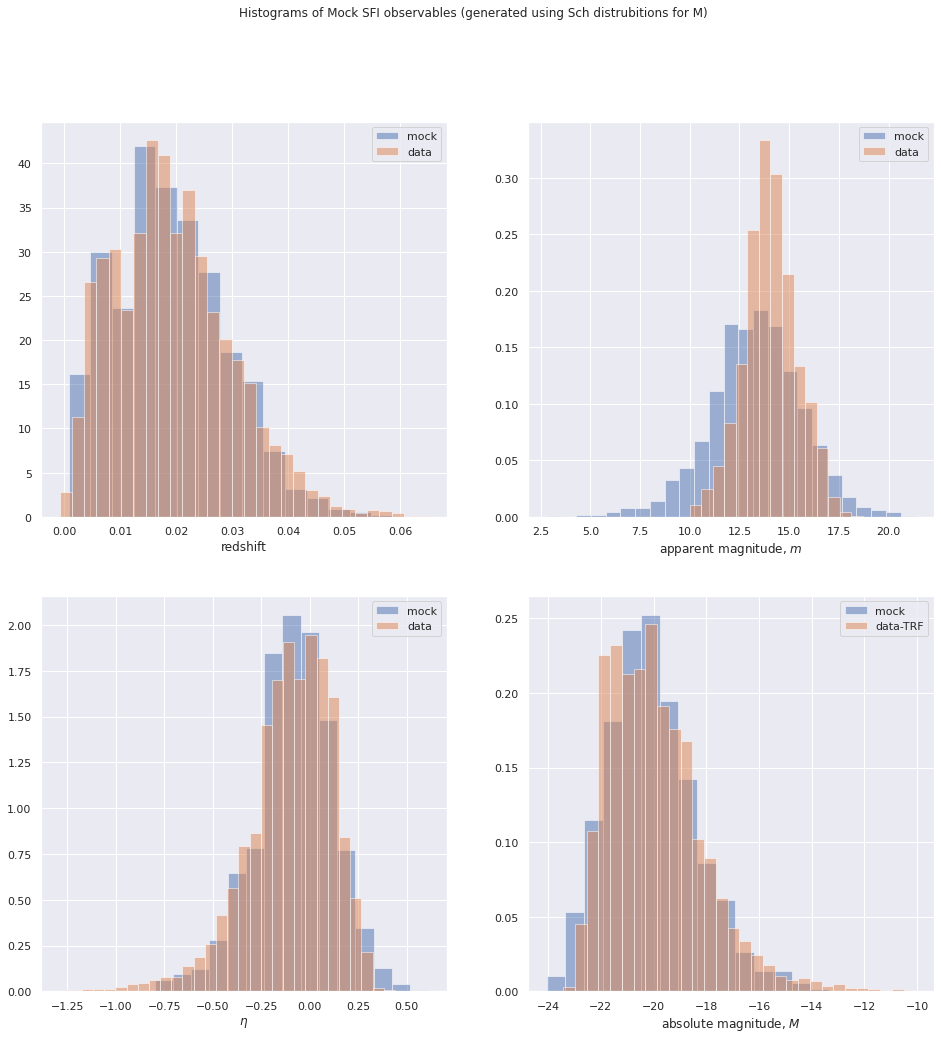

In [71]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle('Histograms of Mock SFI observables (generated using Sch distrubitions for M)')

ax1.hist(mock.data_dict()['z'], bins=15, alpha=0.5, label='mock', density=True)
ax1.hist(np.array(zobs), alpha=0.5,bins=30, label='data', density=True)
ax1.set(xlabel='redshift')
ax1.legend()
ax2.hist(mock.data_dict()['mc'], alpha=0.5,bins=25, label='mock', density=True)
ax2.hist(Imag_cf4_corr_dust,  alpha=0.5,bins=15, label='data', density=True)
ax2.set(xlabel='apparent magnitude, $m$')
ax2.legend()
ax3.hist((mock.data_dict()['xc']), alpha=0.5, bins=15, label='mock', density=True)
ax3.hist((logW_cf4-2.5), bins=30, alpha=0.5, label='data', density=True)
ax3.set(xlabel='$\eta$')
ax3.legend()
ax4.hist(mock.data_dict()['Mc'], alpha=0.5,bins=15, label='mock', density=True)
absMag = curved_TFR((logW_cf4-2.5))
ax4.hist(np.array(absMag),  alpha=0.5,bins=30, label='data-TRF', density=True)
ax4.set(xlabel='absolute magnitude, $M$')
ax4.legend()

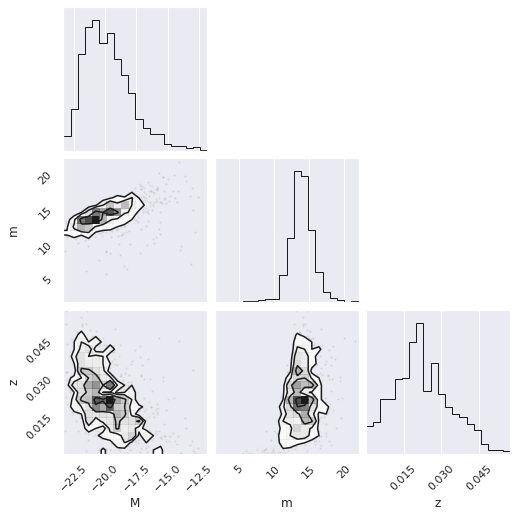

In [51]:
finite_inds_z = np.where(np.isnan(np.array(mock.data_dict()['zhubble']))==False)[0]
finite_inds_M = np.where(np.isnan(np.array(mock.data_dict()['Mc']))==False)[0]
finite_inds_m = np.where(np.isnan(np.array(mock.data_dict()['mc']))==False)[0]
finite_inds = np.intersect1d(finite_inds_z,finite_inds_M)
finite_inds = np.intersect1d(finite_inds, finite_inds_m)
fig2 = corner.corner(np.array([np.array(mock.data_dict()['Mc'])[finite_inds], np.array(mock.data_dict()['mc'])[finite_inds], np.array(mock.data_dict()['zhubble'])[finite_inds]]).T, labels=['M', 'm','z'])

plt.show()

No handles with labels found to put in legend.


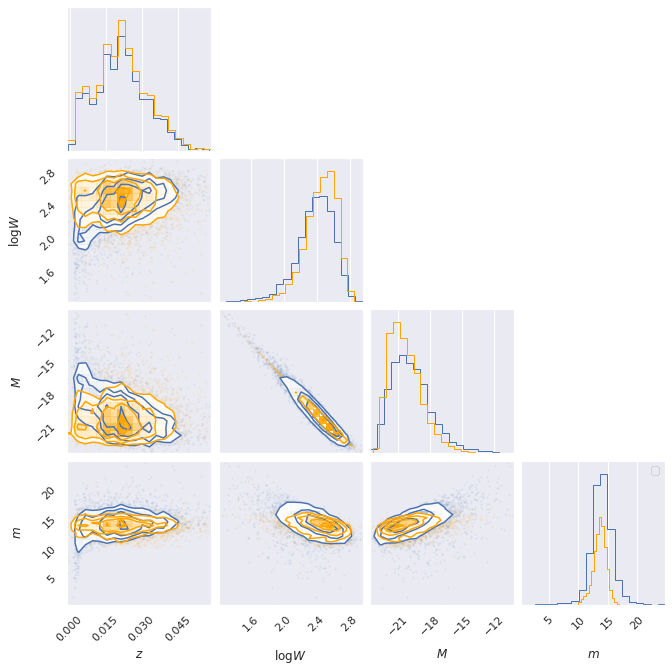

In [73]:


finite_inds_z = np.where(np.isnan(np.array(zobs))==False)[0]
finite_inds_M = np.where(np.isnan(np.array(absMag))==False)[0]
finite_inds_m = np.where(np.isnan(np.array(Imag_cf4_corr_dust))==False)[0]
finite_inds_W = np.where(np.isnan(np.array(logW_cf4))==False)[0]

finite_inds = np.intersect1d(finite_inds_z,finite_inds_M)
finite_inds = np.intersect1d(finite_inds, finite_inds_m)
finite_inds = np.intersect1d(finite_inds, finite_inds_W)

finite_inds_z = np.where(np.isnan(np.array(mock.data_dict()['z']))==False)[0]
finite_inds_M = np.where(np.isnan(np.array(mock.data_dict()['Mc']))==False)[0]
finite_inds_m = np.where(np.isnan(np.array(mock.data_dict()['mc']))==False)[0]
finite_inds_W = np.where(np.isnan(np.array(mock.data_dict()['xc']))==False)[0]

finite_inds2 = np.intersect1d(finite_inds_z,finite_inds_M)
finite_inds2 = np.intersect1d(finite_inds2, finite_inds_m)
finite_inds2 = np.intersect1d(finite_inds2, finite_inds_W)



fig1 = corner.corner(np.array([np.array(mock.data_dict()['z'])[finite_inds2], np.array(mock.data_dict()['xc']+2.5)[finite_inds2], np.array(mock.data_dict()['Mc'])[finite_inds2], np.array(mock.data_dict()['mc'])[finite_inds2]]).T, labels=['$z$','log$W$','$M$', '$m$'],color='b',label='mock')

corner.corner(np.array([np.array(zobs)[finite_inds], np.array(logW_cf4)[finite_inds], np.array(absMag)[finite_inds], np.array(Imag_cf4_corr_dust)[finite_inds]]).T, labels=['$z$','log$W$','$M$', '$m$'], fig=fig1,color='orange',label='CF4 data')
plt.legend()
plt.show()

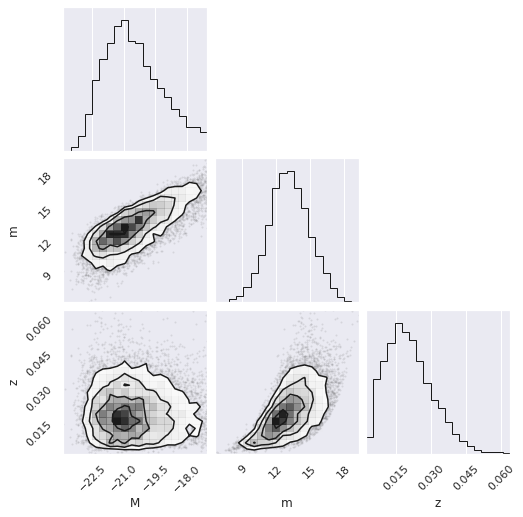

In [32]:

fig2 = corner.corner(np.array([qin_Mag, qin_mag, qin_z]).T, labels=['M', 'm','z'])

plt.show()

## Tully-Fisher Relationship of the mocks

Assume the following linear relationship
\begin{equation}
M - 5\textrm{log}(h) = a ( \textrm{log}(W) - 2.5 ) + b,
\end{equation}

where $a = -7.85$ and $b = -20.85$ and an instrinsic scatter of $\epsilon = 0.35 - 0.37(\textrm{log}(W) - 2.5)$

and 

absolute magnitude, $ M = m + \log{r} $

-7.866510155845474 -20.736931707945352
-8.32 -20.8


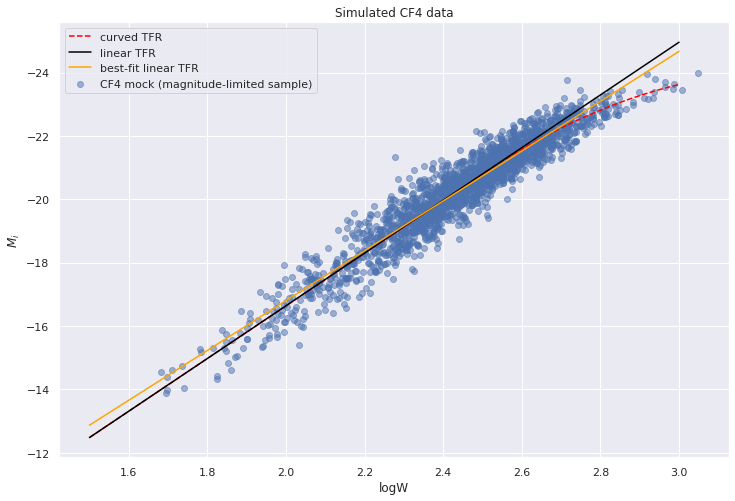

In [54]:
plt.figure(figsize=(12, 8))
plt.scatter(mock.data_dict()['xc']+2.5,mock.data_dict()['yc'],label='CF4 mock (magnitude-limited sample)', alpha=0.5)
plt.plot(x_bins+2.5, curved_TFR(x_bins), label='curved TFR',color='red', linestyle='dashed')
plt.plot(x_bins+2.5, linear_TFR(x_bins), label='linear TFR',color='black')

best_fit = linregress(np.array(mock.data_dict()['xc']),np.array(mock.data_dict()['yc']))
                      
plt.plot(x_bins+2.5, best_fit.slope*(x_bins)+best_fit.intercept, label='best-fit linear TFR',color='orange')

print(linregress(np.array(mock.data_dict()['xc']),np.array(mock.data_dict()['yc'])).slope, linregress(np.array(mock.data_dict()['xc']),np.array(mock.data_dict()['yc'])).intercept)
print(a_TF,b_TF)

plt.gca().invert_yaxis()
plt.xlabel('logW')
plt.ylabel('$M_{i}$')
plt.title('Simulated CF4 data')
plt.legend()
plt.savefig('simulated_TFR.png')

-8.267856710459176 -20.780636936130545
-8.32 -20.8


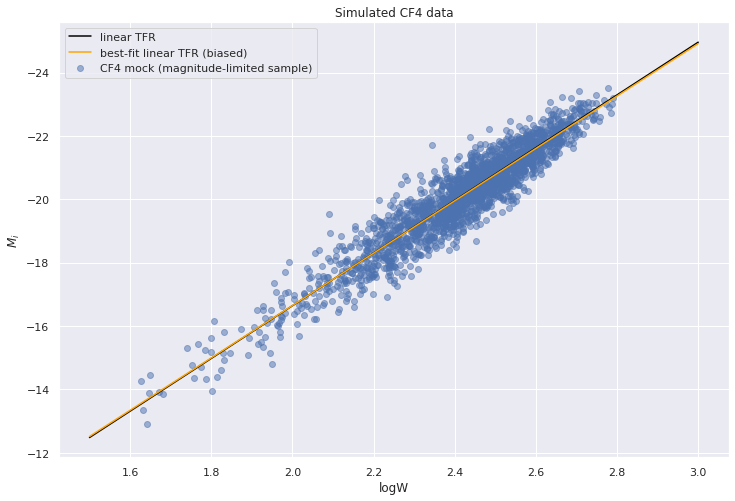

In [51]:
plt.figure(figsize=(12, 8))
plt.scatter(mock.data_dict()['xc']+2.5,mock.data_dict()['yc'],label='CF4 mock (magnitude-limited sample)', alpha=0.5)
plt.plot(x_bins+2.5, linear_TFR(x_bins), label='linear TFR',color='black')

best_fit = linregress(np.array(mock.data_dict()['xc']),np.array(mock.data_dict()['yc']))
                      
plt.plot(x_bins+2.5, best_fit.slope*(x_bins)+best_fit.intercept, label='best-fit linear TFR (biased)',color='orange')

print(linregress(np.array(mock.data_dict()['xc']),np.array(mock.data_dict()['yc'])).slope, linregress(np.array(mock.data_dict()['xc']),np.array(mock.data_dict()['yc'])).intercept)
print(a_TF,b_TF)

plt.gca().invert_yaxis()
plt.xlabel('logW')
plt.ylabel('$M_{i}$')
plt.title('Simulated CF4 data')
plt.legend()
#plt.savefig('simulated_TFR.png')

## Departure from Hubble's law due to peculiar velocities (mock)

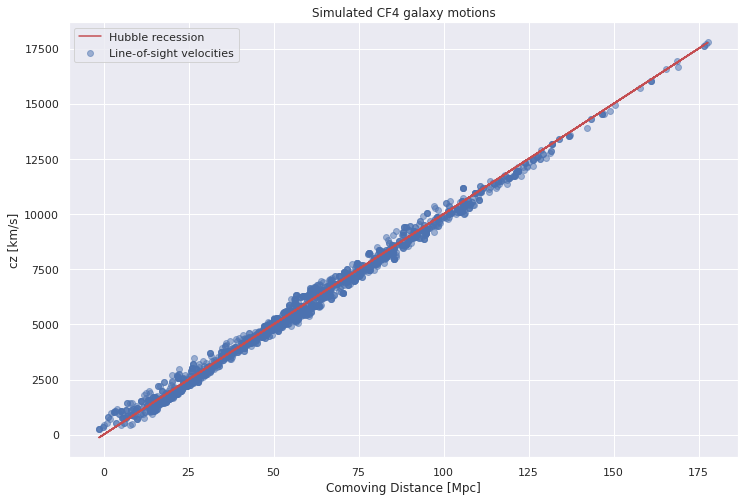

In [77]:
plt.figure(figsize=(12, 8))
plt.scatter( mock.data_dict()['r'], c*mock.data_dict()['z'], label='Line-of-sight velocities',alpha=0.5)
plt.plot(mock.data_dict()['r'], mock.data_dict()['r']*100,  label='Hubble recession',color='r')

plt.legend()
plt.ylabel('cz [km/s]')
plt.xlabel('Comoving Distance [Mpc]')
plt.title('Simulated CF4 galaxy motions')
plt.savefig('PV-sim.png')

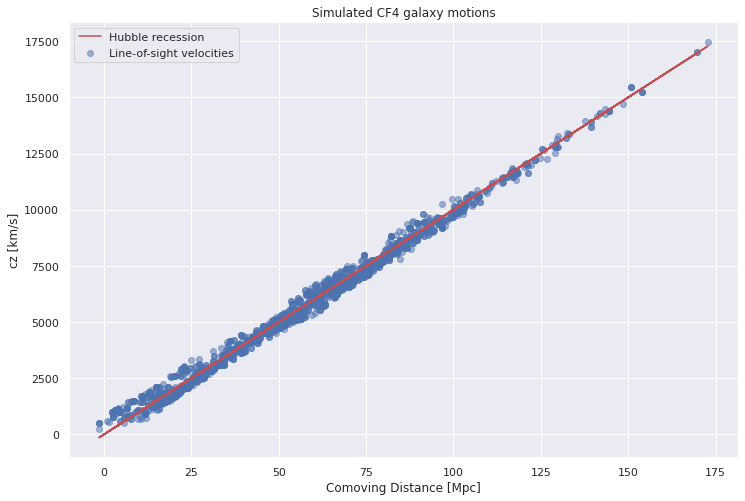

In [80]:
plt.figure(figsize=(12, 8))
plt.scatter( mock.data_dict()['r'], c*mock.data_dict()['z'], label='Line-of-sight velocities',alpha=0.5)
plt.plot(mock.data_dict()['r'], mock.data_dict()['r']*100,  label='Hubble recession',color='r')

plt.legend()
plt.ylabel('cz [km/s]')
plt.xlabel('Comoving Distance [Mpc]')
plt.title('Simulated CF4 galaxy motions')
plt.savefig('PV-sim.png')

Intrinsic scatter of peculiar velocities:
$ \sigma_{v} = 150 \textrm{ km/s} $

Combined error in the TF forward model (scatter in the $r$ direction) and in the observed apparent magnitude:
$ \sigma_{TF}^{2} = \sigma_{r}^{2} + \epsilon_{m}^{2}$


In [88]:
mock_type = 'c'
m = mock.data_dict()['m'+mock_type]

finite_inds = np.where(np.isfinite(m))[0]

m = mock.data_dict()['m'+mock_type][finite_inds]
z = mock.data_dict()['z'][finite_inds]
x = mock.data_dict()['x'+mock_type][finite_inds]
yerr = np.sqrt(mock.data_dict()['Eyy'+mock_type][finite_inds]) # observational error in magnitude
eTF = mock.data_dict()['sig'+mock_type][finite_inds] # intrinsic scatter in TF relation

pred = mock.data_dict()['pv_norm'][finite_inds]
ra = mock.data_dict()['RA'][finite_inds]
dec = mock.data_dict()['DEC'][finite_inds]


sigma_v = 30 # km/s from Carrick et al.

r = mock.data_dict()['r'][finite_inds]
r_range = r

CCC = SkyCoord(mock.data_dict()['RA'][finite_inds], mock.data_dict()['DEC'][finite_inds], frame='icrs', unit='deg')
SGL = CCC.transform_to('supergalactic').sgl.value
SGB = CCC.transform_to('supergalactic').sgb.value

DU = np.array(_eq_to_cart(SGL, SGB)).T

## Forward joint likelihood

The joint probability:
$P(\eta,m,cz,\mathbf{r}) = \frac{1}{\sqrt{2\pi}\sigma_{TF}} \exp \left[ -\frac{[m - (M(\eta)+\mu(r))]^{2}}{2\sigma^{2}_{TF}} \right] 
\frac{1}{\sqrt{2\pi}\sigma_{v}} \exp \left[ -\frac{(cz - [r+u(\mathbf{r})])^{2}}{2\sigma^{2}_{v}} \right] r^{2} (1+\delta_{g}(\mathbf{r})).$

The log-likelihood:
$\textrm{ln} \mathcal{L} = -\frac{1}{2} \sum_{n=1}^{N_{g}} \frac{1}{S_{n}} \left[ \frac{[m - (M(\eta)+\mu(r))]^{2}}{\sigma^{2}_{TF}} + \textrm{ln}(\sigma^{2}_{TF}) \right.
  \left. + \frac{(cz - [r+u(\mathbf{r})])^{2}}{\sigma^{2}_{v}}+ \textrm{ln}(\sigma^{2}_{v}) - 2 \textrm{ln}(r^{2}(1+\delta_{g}(\mathbf{r}))) \right]_{n}$

In [89]:

def log_likelihood_TF(theta, x, m, z, yerr, sigma_TF, sgl, sgb, r_range):
    a, b, beta, vext_x, vext_y, vext_z = theta
    sigma2 = yerr ** 2 + sigma_TF ** 2
    
    ret = 0
    simga_v = 30
    
    #for r_samp in r_range:
    #    model = 5*np.log10(np.absolute(r_samp*1e3*h)) + b + (a*x)+5*np.log10(h)
    #    ret+= -0.5 * np.sum((m - model) ** 2 / sigma2 + np.log(sigma2))
    #return ret/len(r_range)

    model = 5*np.log10(np.absolute(mock.data_dict()['dL'][finite_inds]*1e5)) + b + (a*x)+5*np.log10(h)
    
    return -0.5 * np.nansum((m - model) ** 2 / sigma2 + np.log(sigma2))
    

def log_likelihood_PV(theta, x, m, z, yerr, sigma_TF, sgl, sgb, r_range):
    a, b, beta, vext_x, vext_y, vext_z = theta
    sigma_v = 30
    #du = np.array(_eq_to_cart(ra, dec)).T #unit direction of galaxy
    du = np.array(_eq_to_cart(sgl, sgb)).T
    vext_r = np.dot(du, [vext_x, vext_y, vext_z])
    sigma2 = sigma_v ** 2
    pv = beta*mock.data_dict()['pv_norm'][finite_inds] + vext_r
    #pv = mock.data_dict()['pv'][finite_inds]
    ret = 0
    
    #for r_samp in r_range:
    #    model = r_samp*100 + pv
    #    ret+= -0.5 * np.sum((c*z - model) ** 2 / sigma2 + np.log(sigma2))
    #return ret/len(r_range)


    model = mock.data_dict()['r'][finite_inds]*100 + pv
    return -0.5 * np.nansum((c*z - model) ** 2 / sigma2 + np.log(sigma2))
    

def log_prior(theta):
    a, b, beta, vext_x, vext_y, vext_z = theta
    if -50.0 < a < 50.0 and -50.0 < b < 50.0 and 0 < beta < 2.0:# and -50.0 < sigma_r < 50.0: #and 0 < r < 200000 
        return 0.0
    return -np.inf

def log_probability(theta, x, m, z, yerr, sigma_TF, sgl, sgb):
    lp = log_prior(theta)
    central_r = c*z
    std_r = 50
    r_range = np.linspace(central_r - (3 * std_r) , central_r + (3 * std_r) , num=30)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_TF(theta, x, m, z, yerr, sigma_TF, sgl, sgb, r_range) + log_likelihood_PV(theta, x, m, z, yerr, sigma_TF, sgl, sgb, r_range)


In [90]:
def log_likelihood_ML(theta, x, m, z, yerr, sigma_TF, sgl, sgb):
    a, b, beta, vext_x, vext_y, vext_z = theta
    
    sigma_v = 30
    
    model = 5*np.log10((mock.data_dict()['dL'][finite_inds]*1e5)) + b + (a*x)+5*np.log10(h)

    sigma2 = yerr ** 2 + sigma_TF ** 2
    l1 = -0.5 * np.sum((m - model) ** 2 / sigma2 + np.log(sigma2))
    
    #du = np.array(_eq_to_cart(ra, dec)).T #unit direction of galaxy
    du = np.array(_eq_to_cart(sgl, sgb)).T
    vext_r = np.dot(du, [vext_x, vext_y, vext_z])
    pv = beta*mock.data_dict()['pv_norm'][finite_inds] + vext_r
    #pv = mock.data_dict()['pv'][finite_inds]
    model_PV = mock.data_dict()['r'][finite_inds]*100 + pv
    sigma2_PV = sigma_v ** 2
    l2 = -0.5 * np.nansum((c*z - model_PV) ** 2 / sigma2_PV + np.log(sigma2_PV))
    
    return l1 + l2


In [91]:
true_params = np.array([a_TF, b_TF, beta_true, vext_true[0], vext_true[1], vext_true[2]])
#true_params = np.array([a_TF, b_TF, beta_true, 50, 50, vext_true[2]])

np.random.seed(42)
nll = lambda *args: -log_likelihood_ML(*args)
initial = true_params + 0.1 * np.random.randn(6)

soln = minimize(nll, initial, args=(mock.data_dict()['x'+mock_type][finite_inds], mock.data_dict()['m'+mock_type][finite_inds], mock.data_dict()['z'][finite_inds], mock.data_dict()['Eyy'+mock_type][finite_inds], mock.data_dict()['sig'+mock_type][finite_inds], SGL, SGB))
a_ml, b_ml, beta_ml, vext_x_ml, vext_y_ml, vext_z_ml = soln.x

In [85]:
soln.x, true_params

(array([  -7.63809881,  -20.11474721,    0.42206269,  111.78620569,
        -110.87069572,   26.97604997]),
 array([  -8.32,  -20.8 ,    0.43,   89.  , -131.  ,   17.  ]))

In [92]:
soln.x, true_params

(array([  -7.86309952,  -20.10403138,    0.42904949,   89.83308017,
        -129.80771463,   17.42865729]),
 array([  -8.32,  -20.8 ,    0.43,   89.  , -131.  ,   17.  ]))

In [539]:
pos = soln.x + 1e-4 * np.random.randn(32, 6)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mock.data_dict()['x'+mock_type][finite_inds], mock.data_dict()['m'+mock_type][finite_inds], mock.data_dict()['z'][finite_inds], mock.data_dict()['Eyy'+mock_type][finite_inds], mock.data_dict()['sig'+mock_type][finite_inds], SGL, SGB))
sampler.run_mcmc(pos, 5000, progress=True);
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

100%|██████████| 5000/5000 [01:10<00:00, 70.90it/s]


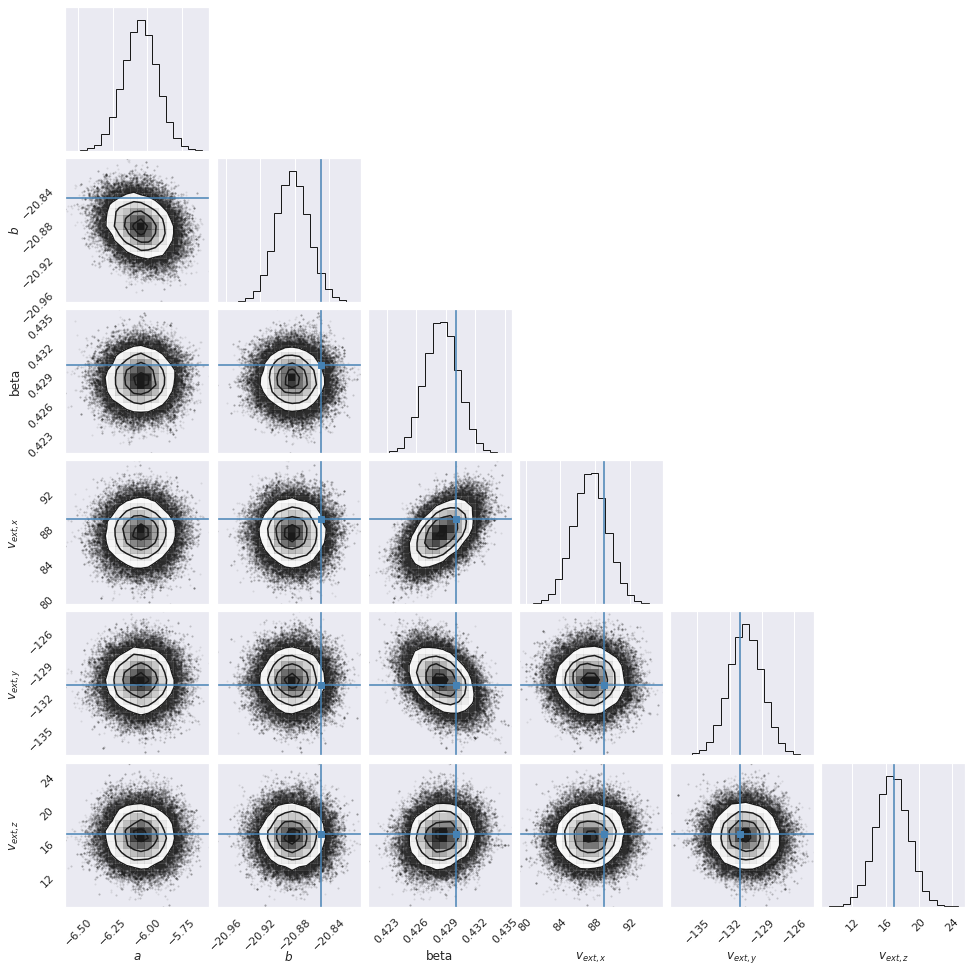

In [540]:
fig = corner.corner(samples, labels=["$a$", "$b$", "beta", "$v_{ext, x}$",  "$v_{ext, y}$",  "$v_{ext, z}$"], truths=true_params)
plt.show()


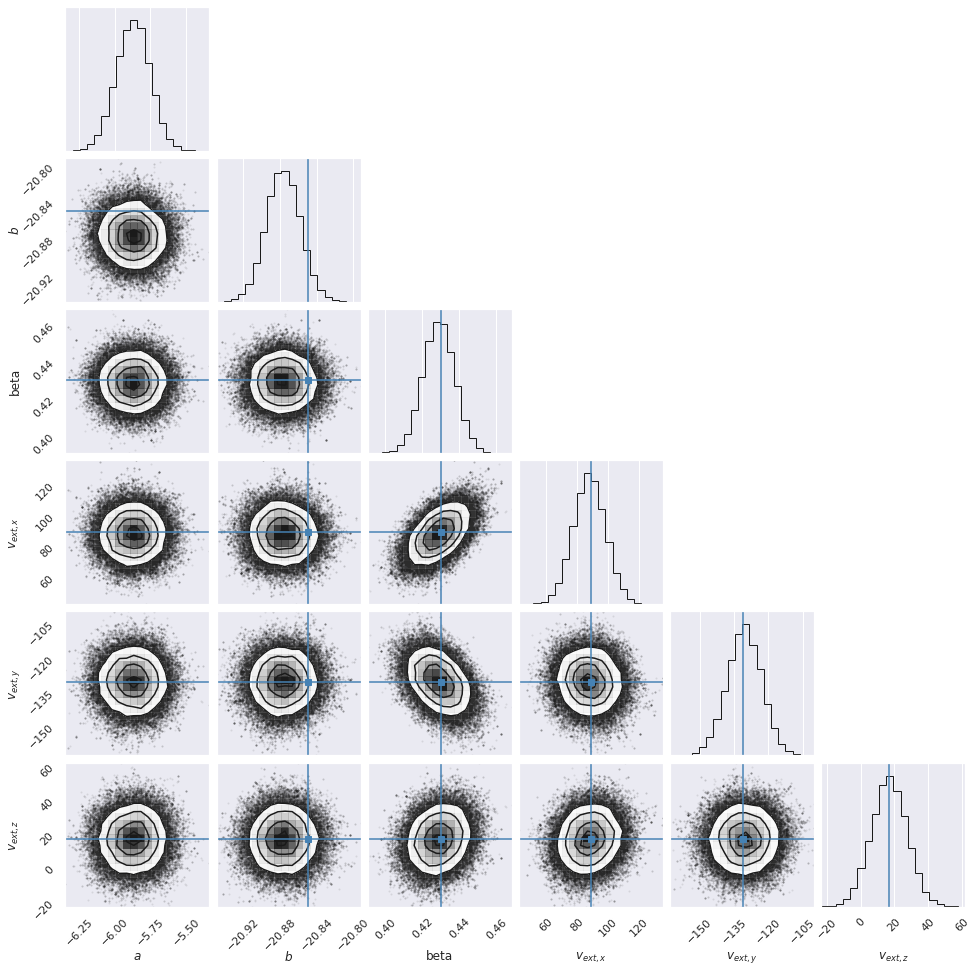

In [344]:
fig = corner.corner(samples, labels=["$a$", "$b$", "beta", "$v_{ext, x}$",  "$v_{ext, y}$",  "$v_{ext, z}$"], truths=true_params)
plt.show()


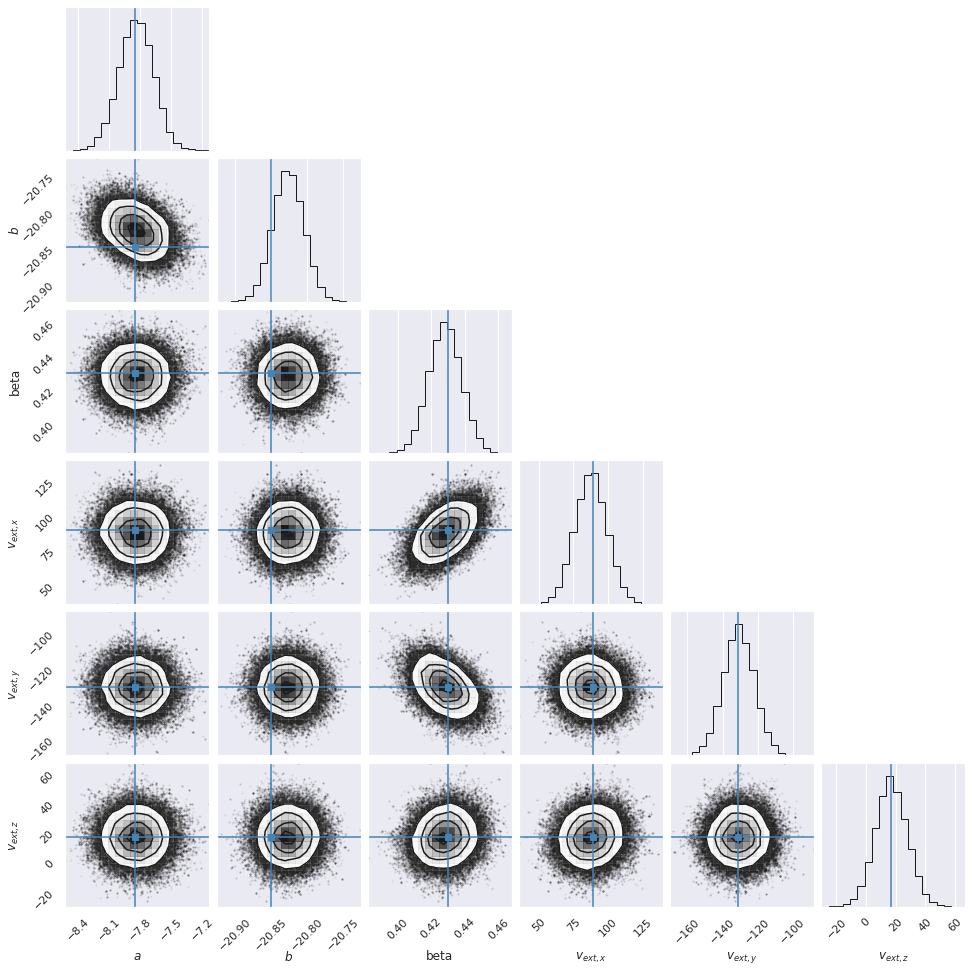

In [207]:
#Schechter LF Mock
fig = corner.corner(samples, labels=["$a$", "$b$", "beta", "$v_{ext, x}$",  "$v_{ext, y}$",  "$v_{ext, z}$"], truths=true_params)
plt.show()
